In [66]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [3]:
with open("movielens/users.json", "r") as f:
    user_ids = json.load(f)
print(user_ids)

[3501, 70691, 122780, 69353, 74069, 29330, 83325, 42971, 100206, 64094, 14549, 8512, 110161, 8388, 54160, 15961]


In [6]:
ratings = pd.read_csv('../data/rating.csv').rename(columns={"userId": 'u_id',  "movieId": "i_id"})
movies = pd.read_csv('../data/movie.csv').rename(columns={"movieId": "i_id"})
genres = pd.DataFrame({k: {g: True for g in v} for k, v in movies.set_index('i_id').genres.apply(lambda gs: gs.split("|")).to_dict().items()}).fillna(False).transpose()


In [9]:
ratings.head()

,u_id,i_id,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [10]:
movies.head()

,i_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
1,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Analysie selected users

In [31]:
GENRE1 = "Action"
GENRE2 = "Romance"

In [70]:
rat_sel = ratings[ratings.u_id.isin(user_ids)]
rat_sel.shape

(2450, 4)

Number of ratings posted:

In [15]:
rat_sel.groupby('u_id').count().i_id

u_id
3501        26
8388        21
8512        31
14549      243
15961       56
29330       32
42971      146
54160     1318
64094      252
69353       76
70691       24
74069       22
83325       31
100206      78
110161      57
122780      37
Name: i_id, dtype: int64

User genre interests:

In [18]:
genres.reset_index()

,index,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,True,True,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,False,False,False,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,131254,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27274,131256,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27275,131258,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27276,131260,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [26]:
user_genres = pd.merge(rat_sel, genres.reset_index().rename(columns={'index': 'i_id'}), on='i_id', how='left').groupby('u_id').sum().drop(['rating', 'i_id'], axis=1)
user_genres

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
u_id,,,,,,,,,,,,,,,,,,,,
3501,11,2,2,7,1,5,9,14,7,13,0,0,6,2,0,2,2,1,0,0
8388,4,1,1,12,1,5,10,4,2,3,0,1,3,0,0,1,1,3,0,0
8512,10,0,0,9,2,6,11,17,8,9,3,1,6,0,0,1,0,0,0,0
14549,65,14,18,88,33,60,133,70,44,55,6,14,24,20,6,12,7,5,1,0
15961,9,4,3,26,9,7,26,8,9,8,1,4,9,1,4,5,0,1,0,0
29330,6,3,0,13,2,0,10,9,11,12,6,8,6,0,0,1,1,1,2,0
42971,43,2,3,30,8,14,55,63,16,39,15,6,84,0,1,26,4,2,4,0
54160,149,29,39,451,71,220,696,254,284,399,114,129,130,6,51,49,32,22,16,0
64094,75,23,19,83,34,28,101,89,45,68,16,19,66,7,8,17,16,5,3,0


In [30]:
(user_genres.transpose() / user_genres.transpose().sum()).transpose()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
u_id,,,,,,,,,,,,,,,,,,,,
3501,0.130952,0.023810,0.023810,0.083333,0.011905,0.059524,0.107143,0.166667,0.083333,0.154762,0.000000,0.000000,0.071429,0.023810,0.000000,0.023810,0.023810,0.011905,0.000000,0.0
8388,0.076923,0.019231,0.019231,0.230769,0.019231,0.096154,0.192308,0.076923,0.038462,0.057692,0.000000,0.019231,0.057692,0.000000,0.000000,0.019231,0.019231,0.057692,0.000000,0.0
8512,0.120482,0.000000,0.000000,0.108434,0.024096,0.072289,0.132530,0.204819,0.096386,0.108434,0.036145,0.012048,0.072289,0.000000,0.000000,0.012048,0.000000,0.000000,0.000000,0.0
14549,0.096296,0.020741,0.026667,0.130370,0.048889,0.088889,0.197037,0.103704,0.065185,0.081481,0.008889,0.020741,0.035556,0.029630,0.008889,0.017778,0.010370,0.007407,0.001481,0.0
15961,0.067164,0.029851,0.022388,0.194030,0.067164,0.052239,0.194030,0.059701,0.067164,0.059701,0.007463,0.029851,0.067164,0.007463,0.029851,0.037313,0.000000,0.007463,0.000000,0.0
29330,0.065934,0.032967,0.000000,0.142857,0.021978,0.000000,0.109890,0.098901,0.120879,0.131868,0.065934,0.087912,0.065934,0.000000,0.000000,0.010989,0.010989,0.010989,0.021978,0.0
42971,0.103614,0.004819,0.007229,0.072289,0.019277,0.033735,0.132530,0.151807,0.038554,0.093976,0.036145,0.014458,0.202410,0.000000,0.002410,0.062651,0.009639,0.004819,0.009639,0.0
54160,0.047437,0.009233,0.012416,0.143585,0.022604,0.070041,0.221585,0.080866,0.090417,0.127030,0.036294,0.041070,0.041388,0.001910,0.016237,0.015600,0.010188,0.007004,0.005094,0.0
64094,0.103878,0.031856,0.026316,0.114958,0.047091,0.038781,0.139889,0.123269,0.062327,0.094183,0.022161,0.026316,0.091413,0.009695,0.011080,0.023546,0.022161,0.006925,0.004155,0.0


Initial saturation:

In [33]:
(user_genres.transpose() / user_genres.transpose().sum()).transpose()[[GENRE1, GENRE2]]

,Action,Romance
u_id,,
3501,0.166667,0.059524
8388,0.076923,0.096154
8512,0.204819,0.072289
14549,0.103704,0.088889
15961,0.059701,0.052239
29330,0.098901,0.000000
42971,0.151807,0.033735
54160,0.080866,0.070041
64094,0.123269,0.038781


# Saturation

In [37]:
satur_files = os.listdir('movielens/saturation')

In [40]:
satur_data = {}

for sf in satur_files:
    if re.match("predictions", sf):
        data_tmp = pd.read_parquet(f'movielens/saturation/{sf}')
        index_tmp = int(sf.split("_")[-1].split(".")[0])
        satur_data[index_tmp] = data_tmp

In [69]:
{k: v.shape[0] for k, v in satur_data.items()}

{53: 26720,
 161: 26720,
 263: 26720,
 468: 26720,
 187: 26720,
 350: 26720,
 467: 26720,
 188: 26720,
 285: 26720,
 308: 26720,
 430: 26720,
 307: 26720,
 136: 26720,
 234: 26720,
 139: 26720,
 273: 26720,
 171: 26720,
 43: 26720,
 198: 26720,
 295: 26720,
 340: 26720,
 197: 26720,
 420: 26720,
 317: 26720,
 318: 26720,
 224: 26720,
 129: 26720,
 126: 26720,
 14: 26720,
 447: 26720,
 370: 26720,
 448: 26720,
 95: 26720,
 396: 26720,
 243: 26720,
 73: 26720,
 399: 26720,
 141: 26720,
 119: 26720,
 214: 26720,
 24: 26720,
 116: 26720,
 327: 26720,
 410: 26720,
 328: 26720,
 85: 26720,
 458: 26720,
 457: 26720,
 360: 26720,
 151: 26720,
 63: 26720,
 389: 26720,
 253: 26720,
 386: 26720,
 106: 26720,
 34: 26720,
 109: 26720,
 204: 26720,
 0: 26720,
 338: 26720,
 337: 26720,
 400: 26720,
 176: 26720,
 44: 26720,
 274: 26720,
 179: 26720,
 190: 26720,
 348: 26720,
 292: 26720,
 347: 26720,
 428: 26720,
 310: 26720,
 427: 26720,
 121: 26720,
 13: 26720,
 223: 26720,
 264: 26720,
 169: 26720,

In [47]:
pd.concat(satur_data).sort_index().head()

u_id  i_id  (no genres listed)  Action  Adventure  Animation  Children  \
0 0  3501     1               False   False       True       True      True   
  1  3501     2               False   False       True      False      True   
  2  3501     3               False   False      False      False     False   
  3  3501     6               False    True      False      False     False   
  4  3501     7               False   False      False      False     False   

     Comedy  Crime  Documentary  ...  Musical  Mystery  Romance  Sci-Fi  \
0 0    True  False        False  ...    False    False    False   False   
  1   False  False        False  ...    False    False    False   False   
  2    True  False        False  ...    False    False     True   False   
  3   False   True        False  ...    False    False    False   False   
  4    True  False        False  ...    False    False     True   False   

     Thriller    War  Western  rating  rating_real      pred  
0 0     False  False    False     NaN          NaN  4.095285  
  1     False  False    False     NaN          NaN  3.905592  
  2     False  False    False     NaN          NaN  3.687097  
  3      True  False    False     NaN          NaN  4.223028  
  4     False  False    False     NaN          NaN  3.869582  

[5 rows x 25 columns]

In [73]:
pd.concat(satur_data).sort_index().notna().sum()

u_id                  12558400
i_id                  12558400
(no genres listed)    12558400
Action                12558400
Adventure             12558400
Animation             12558400
Children              12558400
Comedy                12558400
Crime                 12558400
Documentary           12558400
Drama                 12558400
Fantasy               12558400
Film-Noir             12558400
Horror                12558400
IMAX                  12558400
Musical               12558400
Mystery               12558400
Romance               12558400
Sci-Fi                12558400
Thriller              12558400
War                   12558400
Western               12558400
rating                   41360
rating_real            1151500
pred                  12558400
dtype: int64

## Saturation 1

Saturation in 100 best new reccommendations

In [78]:
satur1 = {}
for k, v in satur_data.items():
    satur1[k] = v.groupby("u_id").apply(
        lambda df: df.loc[df.rating_real.isnull() & df.rating.isnull(), :].sort_values("pred")[-100:].drop(["u_id", "i_id", "pred"], axis=1).mean())
satur1df = pd.concat(satur1)

In [79]:
satur1df.head()

(no genres listed)  Action  Adventure  Animation  Children  Comedy  \
   u_id                                                                        
53 3501                  0.0    0.24       0.17       0.01      0.02    0.12   
   8388                  0.0    0.48       0.31       0.07      0.03    0.36   
   8512                  0.0    0.05       0.11       0.05      0.04    0.22   
   14549                 0.0    0.13       0.14       0.07      0.04    0.17   
   15961                 0.0    0.33       0.37       0.11      0.13    0.29   

          Crime  Documentary  Drama  Fantasy  ...  IMAX  Musical  Mystery  \
   u_id                                       ...                           
53 3501    0.19         0.02   0.67     0.03  ...  0.00     0.00     0.09   
   8388    0.32         0.03   0.34     0.12  ...  0.09     0.02     0.10   
   8512    0.16         0.10   0.69     0.05  ...  0.01     0.01     0.11   
   14549   0.17         0.13   0.68     0.06  ...  0.01     0.03     0.16   
   15961   0.16         0.04   0.42     0.15  ...  0.08     0.04     0.09   

          Romance  Sci-Fi  Thriller   War  Western  rating  rating_real  
   u_id                                                                  
53 3501      0.17    0.02      0.30  0.19     0.03     NaN          NaN  
   8388      0.11    0.13      0.22  0.08     0.05     NaN          NaN  
   8512      0.26    0.02      0.18  0.09     0.00     NaN          NaN  
   14549     0.24    0.06      0.14  0.14     0.01     NaN          NaN  
   15961     0.17    0.11      0.17  0.10     0.04     NaN          NaN  

[5 rows x 22 columns]

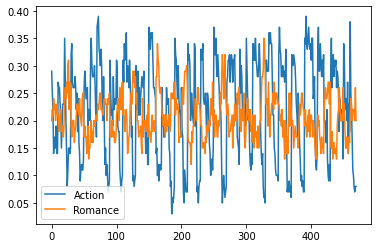

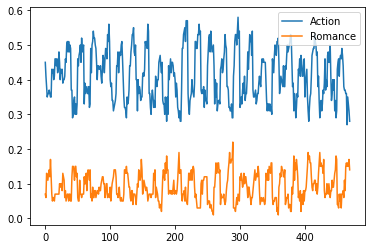

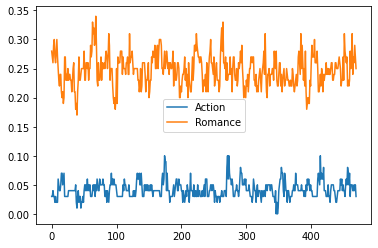

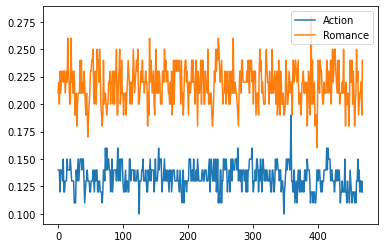

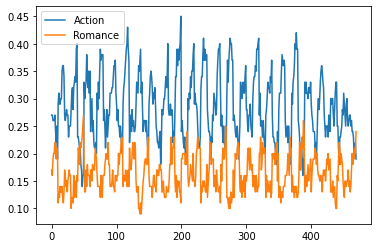

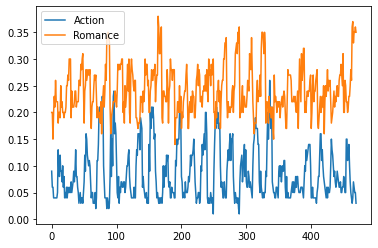

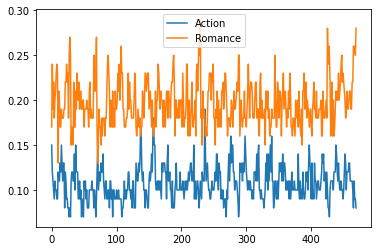

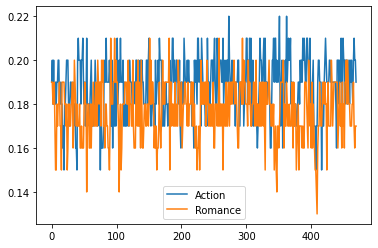

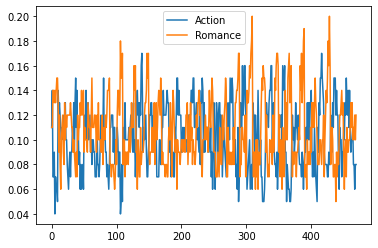

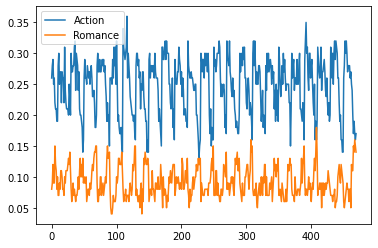

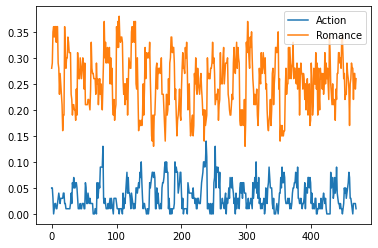

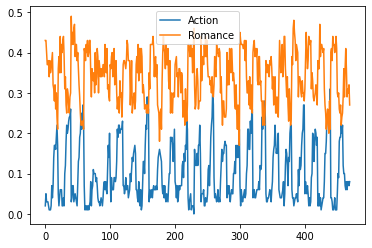

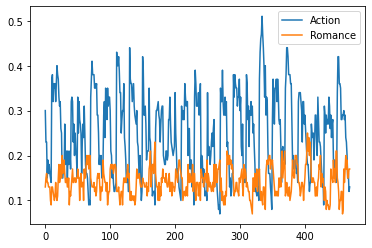

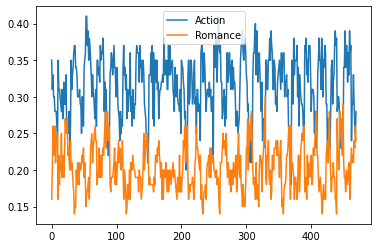

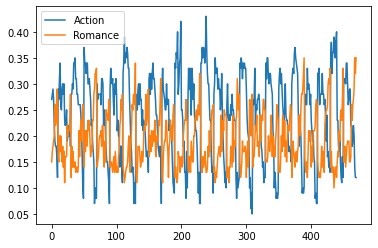

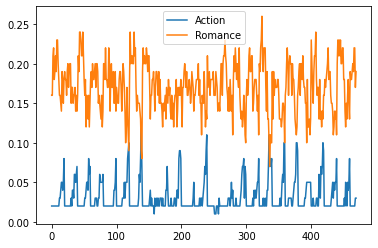

In [80]:
satur1df.sort_index()[[GENRE1, GENRE2]].reset_index(level=1).groupby('u_id').plot(y=[GENRE1, GENRE2])
plt.show()